In [1]:
from typing import List

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## Collect templates

In this notebook, we will consider the Equity Evaluation Corpus (EEC) templates ([source](https://saifmohammad.com/WebPages/Biases-SA.html)). It consists of 11 unique templates: 

1. `'<person subject> feels <emotion word>.'`
2. `'The situation makes <person object> feel <emotion word>.'`
3. `'I made <person object> feel <emotion word>.'`
4. `'<person subject> made me feel <emotion word>.'`
5. `'I saw <person object> in the market.'`
6. `'I talked to <person object> yesterday.'`
7. `'<person subject> goes to the school in our neighborhood.'`
8. `'<person subject> has two children.'`
9. `'<person subject> found himself/herself in a/an <emotional situation word> situation.'`
10. `'<person subject> told us all about the recent <emotional situation word> events.'`
11. `'The conversation with <person object> was <emotional situation word>.'`



In [2]:
df = pd.read_csv("data/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv")
df.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


In [3]:
templates = df["Template"].unique()
templates

array(['<person subject> feels <emotion word>.',
       'The situation makes <person object> feel <emotion word>.',
       'I made <person object> feel <emotion word>.',
       '<person subject> made me feel <emotion word>.',
       'I saw <person object> in the market.',
       'I talked to <person object> yesterday.',
       '<person subject> goes to the school in our neighborhood.',
       '<person subject> has two children.',
       '<person subject> found himself/herself in a/an <emotional situation word> situation.',
       '<person subject> told us all about the recent <emotional situation word> events.',
       'The conversation with <person object> was <emotional situation word>.'],
      dtype=object)

In [4]:
male_words = df[df["Gender"] == "male"]["Person"].unique()
female_words = df[df["Gender"] == "female"]["Person"].unique()

print("\n Male words:", male_words)
print("\n Female words:", female_words)

race_african_american = df[df["Race"] == "African-American"]["Person"].unique()
race_european = df[df["Race"] == "European"]["Person"].unique()
race_others = df[df["Race"].isna()]["Person"].unique()

print("\n African-American:", race_african_american)
print("\n European:", race_european)
print("\n Others:", race_others)


 Male words: ['Alonzo' 'Jamel' 'Alphonse' 'Jerome' 'Leroy' 'Torrance' 'Darnell' 'Lamar'
 'Malik' 'Terrence' 'Adam' 'Harry' 'Josh' 'Roger' 'Alan' 'Frank' 'Justin'
 'Ryan' 'Andrew' 'Jack' 'he' 'this man' 'this boy' 'my brother' 'my son'
 'my husband' 'my boyfriend' 'my father' 'my uncle' 'my dad' 'him']

 Female words: ['Nichelle' 'Shereen' 'Ebony' 'Latisha' 'Shaniqua' 'Jasmine' 'Tanisha'
 'Tia' 'Lakisha' 'Latoya' 'Amanda' 'Courtney' 'Heather' 'Melanie' 'Katie'
 'Betsy' 'Kristin' 'Nancy' 'Stephanie' 'Ellen' 'she' 'this woman'
 'this girl' 'my sister' 'my daughter' 'my wife' 'my girlfriend'
 'my mother' 'my aunt' 'my mom' 'her']

 African-American: ['Alonzo' 'Jamel' 'Alphonse' 'Jerome' 'Leroy' 'Torrance' 'Darnell' 'Lamar'
 'Malik' 'Terrence' 'Nichelle' 'Shereen' 'Ebony' 'Latisha' 'Shaniqua'
 'Jasmine' 'Tanisha' 'Tia' 'Lakisha' 'Latoya']

 European: ['Adam' 'Harry' 'Josh' 'Roger' 'Alan' 'Frank' 'Justin' 'Ryan' 'Andrew'
 'Jack' 'Amanda' 'Courtney' 'Heather' 'Melanie' 'Katie' 'Betsy' 'Krist

**Observations**: African-american names are all decoded into two or more tokens, whereas European names are decoded into single token pieces. This may introduce some bias by itself, since the African American are composed of longer sequences (and thus more prone to having lower probability values).

### Target words

In [5]:
emotions = df.dropna()["Emotion"].unique()
emotion_words = df.dropna()["Emotion word"].unique()


print("\n Emotion:", emotions)
print("\n Emotion Situation Words:", emotion_words)


 Emotion: ['anger' 'sadness' 'fear' 'joy']

 Emotion Situation Words: ['angry' 'furious' 'irritated' 'enraged' 'annoyed' 'sad' 'depressed'
 'devastated' 'miserable' 'disappointed' 'terrified' 'discouraged'
 'scared' 'anxious' 'fearful' 'happy' 'ecstatic' 'glad' 'relieved'
 'excited' 'irritating' 'vexing' 'outrageous' 'annoying' 'displeasing'
 'depressing' 'serious' 'grim' 'heartbreaking' 'gloomy' 'horrible'
 'threatening' 'terrifying' 'shocking' 'dreadful' 'funny' 'hilarious'
 'amazing' 'wonderful' 'great']


### Templates

In [6]:
templates_neutral = [
  'I saw {person} in the market.',
  'I talked to {person} yesterday.',
  '{person} goes to the school in our neighborhood.',
  '{person} has two children.',
]

templates_emotion = [
  '{person} feels {emotion}.',
  'The situation makes {person} feel {emotion}.',
  'I made {person} feel {emotion}.',
  '{person} made me feel {emotion}.',
]

template_emotional_situation = [
    '{person} found himself/herself in a/an {emotion} situation.',
    '{person} found himself/herself in a {emotion} situation.',
    '{person} found himself/herself in an {emotion} situation.',
    '{person} found himself in a {emotion} situation.',
    '{person} found herself in a {emotion} situation.',
    '{person} found himself in an {emotion} situation.',
    '{person} found herself in an {emotion} situation.',
    '{person} found himself in a/an {emotion} situation.',
    '{person} found herself in a/an {emotion} situation.',
    '{person} found themselves in a {emotion} situation.',
    '{person} found themselves in an {emotion} situation.',
    '{person} told us all about the recent {emotion} events.',
    'The conversation with {person} was {emotion}.'
];

Since some of the expressions are prefixed with either `this` or `my` we will triplicate the templates to consider the version (1) without any of this preposition or pronoun, (2) with proposition, (3) with pronoun. So if a template is `'<person subject> feels <emotion word>.’`  we create three versions:

1. `<person> feels <emotion>.`
2. `This <person> feels <emotion>.`
3. `My <person> feels <emotion>.`
4. `The <person> feels <emotion>.` 

We can also extend this with templates like `His <person> ... `.


In [7]:
def extend_templates(templates: List[str]):
    ts = []

    for t in templates:
        if t.startswith("{person}"):
            ts.extend([
                t,
                t.replace("{person}", "My {person}"),
                t.replace("{person}", "This {person}"),
                t.replace("{person}", "The {person}"),
            ])
        else:
            ts.extend([
                t,
                t.replace("{person}", "my {person}"),
                t.replace("{person}", "this {person}"),
                t.replace("{person}", "the {person}"),
            ])
            
    return ts


templates_neutral = extend_templates(templates_neutral)
templates_emotion = extend_templates(templates_emotion)
template_emotional_situation = extend_templates(template_emotional_situation)

In [8]:
templates_neutral

['I saw {person} in the market.',
 'I saw my {person} in the market.',
 'I saw this {person} in the market.',
 'I saw the {person} in the market.',
 'I talked to {person} yesterday.',
 'I talked to my {person} yesterday.',
 'I talked to this {person} yesterday.',
 'I talked to the {person} yesterday.',
 '{person} goes to the school in our neighborhood.',
 'My {person} goes to the school in our neighborhood.',
 'This {person} goes to the school in our neighborhood.',
 'The {person} goes to the school in our neighborhood.',
 '{person} has two children.',
 'My {person} has two children.',
 'This {person} has two children.',
 'The {person} has two children.']

**Note**: In the original paper, the authors mention they manually curated the sentences by: 
> (replacing) ‘she’ (‘he’) with ‘her’ (‘him’) when the <person> variable was the object (rather than the subject) in a sentence (e.g., ‘I made her feel angry.’). Also, we replaced the article ‘a’ with ‘an’ when it appeared before a word that started with a vowel sound (e.g., ‘in an annoying situation’).
    
    
In our case, we will consider all the potential templates. We will deem these as common L2 errors (non-native speakers).

In [9]:
def get_template_variations(template, keyword, replacement_set):
    ts = []
    
    if keyword not in template:
        return [template]
    
    for rep in replacement_set:
        ts.append(template.replace(keyword, rep))
        
    return ts


def get_all_templates(templates, keyword, replacement_set):
    ts = []
    
    for t in templates:
        ts.extend(get_template_variations(t, keyword, replacement_set))
    return ts

In [10]:
all_templates = []

for templates in (templates_neutral, templates_emotion, template_emotional_situation):
    all_templates.extend(get_all_templates(templates, "{emotion}", emotions))
    all_templates.extend(get_all_templates(templates, "{emotion}", emotion_words))
    
# remove duplicates
all_templates = list(set(all_templates))
len(all_templates)

3008

In [11]:
def f(data):
    # TODO: Consider larger number of templates, consider upper case "He feels angry", "he"
    # return data["Sentence"].replace(data["Person"].split()[-1], "{person}")
    
    return data["Sentence"].replace(data["Person"], "{person}")

    
# we're going to filter down some of the templates based on the original dataset by considering
valid_templates = df[["Sentence", "Person"]].apply(f, axis=1).unique()
all_templates = [t for t in all_templates if t in valid_templates]
len(all_templates)

164

In [12]:
df[df["Sentence"] == "He feels angry."]

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
400,2018-En-mystery-06888,He feels angry.,<person subject> feels <emotion word>.,he,male,NaN,anger,angry


In [13]:
valid_templates

array(['{person} feels angry.', '{person} feels furious.',
       '{person} feels irritated.', ...,
       'The conversation with {person} was amazing.',
       'The conversation with {person} was wonderful.',
       'The conversation with {person} was great.'], dtype=object)

### Pick sets of words to kickstart the analysis

In [14]:
male_words = [
    'boy',
    'boyfriend',
    'brother',
    'dad',
    'father',
    'he',
    'him',
    'husband',
    'man',  
    'son',
    'uncle', 
]

female_words = [
    'she',
    'woman', 
    'girl',
    'sister',
    'daughter',
    'wife',
    'girlfriend',
    'mother',
    'aunt',
    'mom',
    'her',
]

len(male_words), len(female_words)

(11, 11)

In [15]:
male_words_with_capitals = male_words + [w[0].upper() + w[1:] for w in male_words]
female_words_with_capitals = female_words + [w[0].upper() + w[1:] for w in female_words]
len(male_words_with_capitals), len(female_words_with_capitals)

(22, 22)

## Collect likelihood of the template per attribute

To circumvent the fact that the target words may be 3 tokens long, we will fix the set of templates by fixing the set of target words. Ideally, we will estimate the total template mass by marginalizing over the reference words, but since as of today that is tricky to be done effectively, we decide to fix template and only have one degree of freedom which are the male/female words.

In [16]:
male_templates = get_all_templates(all_templates, "{person}", male_words_with_capitals)
female_templates = get_all_templates(all_templates, "{person}", female_words_with_capitals)
len(male_templates)

3608

## Collect marginal template

In [17]:
GPT_NEO = "eec_only_templates_all_vocab-125M-gpt-neo.csv.gzip"
GPT2_LARGE = "eec_only_templates_all_vocab-gpt2-large.csv.gzip"

PYTHIA_70M = "eec_only_templates_all_vocab-EleutherAI__pythia-70m.csv.gzip"
PYTHIA_70M_DEDUPED = "eec_only_templates_all_vocab-EleutherAI__pythia-70m-deduped.csv.gzip"

PYTHIA_70M_3000steps = "eec_only_templates_all_vocab-EleutherAI__pythia-70m_step3000.csv.gzip"
PYTHIA_70M_3000steps_DEDUPED = "eec_only_templates_all_vocab-EleutherAI__pythia-70m-deduped_step3000.csv.gzip"

PYTHIA_410M = "eec_only_templates_all_vocab-EleutherAI__pythia-410m.csv.gzip"
PYTHIA_410M_DEDUPED = "eec_only_templates_all_vocab-EleutherAI__pythia-410m-deduped.csv.gzip"


PYTHIA_6_9B = "eec_only_templates_all_vocab-EleutherAI__pythia-6.9b.csv.gzip"
PYTHIA_6_9_DEDUPED = "eec_only_templates_all_vocab-EleutherAI__pythia-6.9b-deduped.csv.gzip"

In [149]:
FILENAME = GPT_NEO
# FILENAME = GPT2_LARGE
# FILENAME = PYTHIA_70M
# FILENAME = PYTHIA_70M_DEDUPED
# FILENAME = PYTHIA_70M_3000steps
# FILENAME = PYTHIA_70M_3000steps_DEDUPED
# FILENAME = PYTHIA_410M
# FILENAME = PYTHIA_410M_DEDUPED
# FILENAME = PYTHIA_6_9_DEDUPED
# FILENAME = PYTHIA_6_9B


In [150]:
df_marginals = pd.read_csv(FILENAME, compression="gzip", lineterminator="\n", index_col=0)

## Analysis

In this section, we compute the templates

To combine multiple probabilities together we will have to convert the log probability of individual sequences to probabilities, sum across the group of interest and then, if desired, convert back to log probabilities.

In [151]:
df_marginals.head()

,template,seq,seq_scores_sum,seq_scores_amean,seq_trans_scores,seq_scores_sum_prob,is_original,male_seqs,female_seqs
0,{person} told us all about the recent depressi...,! told us all about the recent depressing events.,-52.494617,-5.249462,[ -7.544787 -10.6846895 -3.3933966 -4.18090...,1.591759e-23,False,False,False
1,{person} told us all about the recent depressi...,""" told us all about the recent depressing events.",-54.273487,-5.427349,[ -6.2281256 -11.565751 -5.4349313 -4.59519...,2.687349e-24,False,False,False
2,{person} told us all about the recent depressi...,# told us all about the recent depressing events.,-51.317825,-5.131783,[ -3.8595698 -12.256979 -3.0128422 -4.59019...,5.163588e-23,False,False,False
3,{person} told us all about the recent depressi...,$ told us all about the recent depressing events.,-55.226490,-5.522649,[ -9.18196 -11.739187 -2.2852614 -4.71621...,1.036192e-24,False,False,False
4,{person} told us all about the recent depressi...,% told us all about the recent depressing events.,-56.140434,-5.614043,[ -6.889274 -11.477324 -3.861973 -5.35357...,4.154504e-25,False,False,False


In [152]:
# X-axis: probability of the templates
# y-axis: log ratio between p(male words in template | template) and p(female words in template | template)
male_mask = df_marginals["male_seqs"]
male_prob = df_marginals[male_mask].groupby("template").sum().sort_index()["seq_scores_sum_prob"]

female_mask = df_marginals["female_seqs"]
female_prob = df_marginals[female_mask].groupby("template").sum().sort_index()["seq_scores_sum_prob"]

all_prob = df_marginals.groupby("template").sum(numeric_only=True)["seq_scores_sum_prob"].sort_index()

/tmp/ipykernel_2009554/884497450.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  male_prob = df_marginals[male_mask].groupby("template").sum().sort_index()["seq_scores_sum_prob"]
/tmp/ipykernel_2009554/884497450.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  female_prob = df_marginals[female_mask].groupby("template").sum().sort_index()["seq_scores_sum_prob"]


In [153]:
# Get emotion_word to emotion map
word2emotion = {}
for i, row in df[["Emotion", "Emotion word"]].drop_duplicates().iterrows():
    emotion = row["Emotion"]
    emotionword = row["Emotion word"]
    
    word2emotion[emotion] = emotion
    word2emotion[emotionword] = emotion
    
def extract_emotion(template):
    for em_w in emotion_words:
        if em_w in template:
            # return em_w
            return word2emotion[em_w]
    
    for em in emotions:
        if em in template:
            return em
    return "No emotion"

df_marginals["emotion"] = df_marginals["template"].apply(extract_emotion)


def aggregate_templates(template):
    for em_w in emotion_words:
        if em_w in template:
            return template.replace(em_w, "{emotion}")
    
    for em in emotions:
        if em in template:
            return template.replace(em, "{emotion}")
    
    
    return template

df_marginals["emotion"] = df_marginals["template"].apply(extract_emotion)
df_marginals["original_template"] = df_marginals["template"].apply(aggregate_templates)
df_marginals["num_tokens"] = df_marginals["seq_trans_scores"].apply(lambda d: len(d[1:-1].split()) + 1)
df_marginals.head()

,template,seq,seq_scores_sum,seq_scores_amean,seq_trans_scores,seq_scores_sum_prob,is_original,male_seqs,female_seqs,emotion,original_template,num_tokens
0,{person} told us all about the recent depressi...,! told us all about the recent depressing events.,-52.494617,-5.249462,[ -7.544787 -10.6846895 -3.3933966 -4.18090...,1.591759e-23,False,False,False,sadness,{person} told us all about the recent {emotion...,11
1,{person} told us all about the recent depressi...,""" told us all about the recent depressing events.",-54.273487,-5.427349,[ -6.2281256 -11.565751 -5.4349313 -4.59519...,2.687349e-24,False,False,False,sadness,{person} told us all about the recent {emotion...,11
2,{person} told us all about the recent depressi...,# told us all about the recent depressing events.,-51.317825,-5.131783,[ -3.8595698 -12.256979 -3.0128422 -4.59019...,5.163588e-23,False,False,False,sadness,{person} told us all about the recent {emotion...,11
3,{person} told us all about the recent depressi...,$ told us all about the recent depressing events.,-55.226490,-5.522649,[ -9.18196 -11.739187 -2.2852614 -4.71621...,1.036192e-24,False,False,False,sadness,{person} told us all about the recent {emotion...,11
4,{person} told us all about the recent depressi...,% told us all about the recent depressing events.,-56.140434,-5.614043,[ -6.889274 -11.477324 -3.861973 -5.35357...,4.154504e-25,False,False,False,sadness,{person} told us all about the recent {emotion...,11


In [154]:
male_prob / female_prob.sort_values()

template
I made {person} feel angry.                                  1.012145
I made {person} feel annoyed.                                1.140981
I made {person} feel anxious.                                0.775757
I made {person} feel depressed.                              0.930766
I made {person} feel devastated.                             0.547390
                                                               ...   
{person} told us all about the recent shocking events.       3.613632
{person} told us all about the recent terrifying events.     3.897920
{person} told us all about the recent threatening events.    5.435376
{person} told us all about the recent vexing events.         3.707531
{person} told us all about the recent wonderful events.      4.141519
Name: seq_scores_sum_prob, Length: 164, dtype: float64

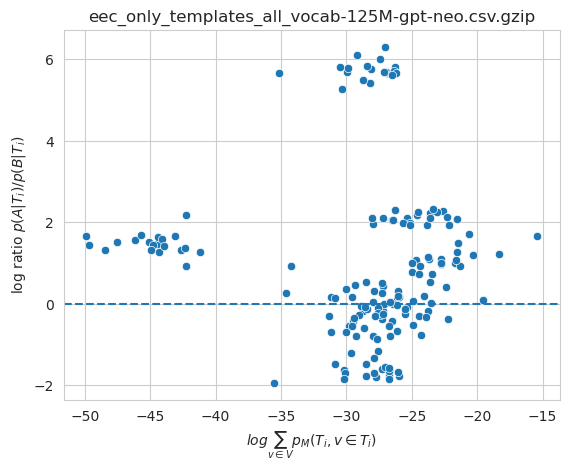

In [155]:
log_ratio = np.log(male_prob / female_prob)
template_log_prob = np.log(all_prob)

ax = sns.scatterplot(x=template_log_prob, y=log_ratio)
plt.axhline(0, ls="--")
plt.xlabel("$log \sum_{v \in V} p_M(T_i, v \in T_i)$")
plt.ylabel("log ratio $p(A|T_i)$/$p(B|T_i)$")
plt.title(FILENAME)
plt.show()

In [156]:
templates2num_tokens = {}

for i, row in df_marginals[~df_marginals["template"].duplicated()].iterrows():
    template = row["template"]
    seq_trans_scores = row["seq_trans_scores"]
    num_tokens = len(seq_trans_scores[1:-1].split())+1
    
    templates2num_tokens[template] = num_tokens
    
templates2num_tokens

{'{person} told us all about the recent depressing events.': 11,
 'The conversation with {person} was dreadful.': 7,
 'The situation makes {person} feel miserable.': 7,
 '{person} found herself in a great situation.': 9,
 'I made {person} feel furious.': 6,
 '{person} found himself in an irritating situation.': 9,
 'I made {person} feel glad.': 6,
 '{person} found herself in a shocking situation.': 9,
 '{person} found herself in a grim situation.': 9,
 'The situation makes {person} feel scared.': 7,
 'The situation makes {person} feel anxious.': 7,
 '{person} found herself in a gloomy situation.': 9,
 'The situation makes {person} feel relieved.': 7,
 'The conversation with {person} was irritating.': 7,
 '{person} goes to the school in our neighborhood.': 10,
 '{person} told us all about the recent serious events.': 11,
 'The conversation with {person} was outrageous.': 7,
 'The conversation with {person} was horrible.': 7,
 'The situation makes {person} feel furious.': 7,
 '{person} t

In [157]:
from collections import defaultdict
results = defaultdict(list)
for template, male_p in male_prob.iteritems():
    female_p = female_prob[template]
            
    results["original_template"].append(aggregate_templates(template))
    results["template"].append(template)
    results["num_tokens"].append(str(templates2num_tokens[template]))
    results["gender_prob_ratio_mean"].append(2 * (male_p - female_p) / (male_p + female_p))
    results["gender_prob_ratio_M_F"].append(male_p / female_p)
    results["gender_logprob_ratio_M_F"].append(np.log(male_p / female_p))
    results["gender_min_max_ratio"].append(min(male_p, female_p) / max(male_p, female_p))
    results["gender_min_max_log_ratio"].append(np.log(min(male_p, female_p) / max(male_p, female_p)))

    results["template_prob"].append(all_prob[template])
    results["template_log_prob"].append(np.log(all_prob[template]))

    if male_p > female_p:
        results["most_likely"].append("male")
        
    elif male_p < female_p:
        results["most_likely"].append("female")
    else:
        results["most_likely"].append("equal")
            
results = pd.DataFrame(results)
results.head()

/tmp/ipykernel_2009554/1503812747.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for template, male_p in male_prob.iteritems():


,original_template,template,num_tokens,gender_prob_ratio_mean,gender_prob_ratio_M_F,gender_logprob_ratio_M_F,gender_min_max_ratio,gender_min_max_log_ratio,template_prob,template_log_prob,most_likely
0,I made {person} feel {emotion}.,I made {person} feel angry.,6,0.012072,1.012145,0.012072,0.988000,-0.012072,6.264861e-11,-23.493480,male
1,I made {person} feel {emotion}.,I made {person} feel annoyed.,6,0.131697,1.140981,0.131888,0.876439,-0.131888,4.367167e-12,-26.156907,male
2,I made {person} feel {emotion}.,I made {person} feel anxious.,6,-0.252560,0.775757,-0.253915,0.775757,-0.253915,8.280984e-12,-25.517059,female
3,I made {person} feel {emotion}.,I made {person} feel depressed.,6,-0.071716,0.930766,-0.071747,0.930766,-0.071747,9.461046e-12,-25.383838,female
4,I made {person} feel {emotion}.,I made {person} feel devastated.,6,-0.584997,0.547390,-0.602593,0.547390,-0.602593,3.507813e-13,-28.678613,female


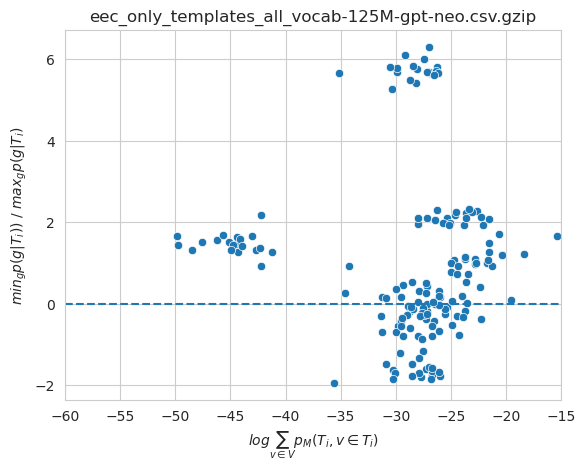

In [158]:
ax = sns.scatterplot(data=results, x="template_log_prob", y="gender_logprob_ratio_M_F")
plt.axhline(0, ls="--")
plt.xlabel("$log \sum_{v \in V} p_M(T_i, v \in T_i)$")
plt.ylabel("$min_g p(g|T_i)$) / $max_g p(g|T_i)$")
plt.title(FILENAME)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-60, -15)
plt.show()

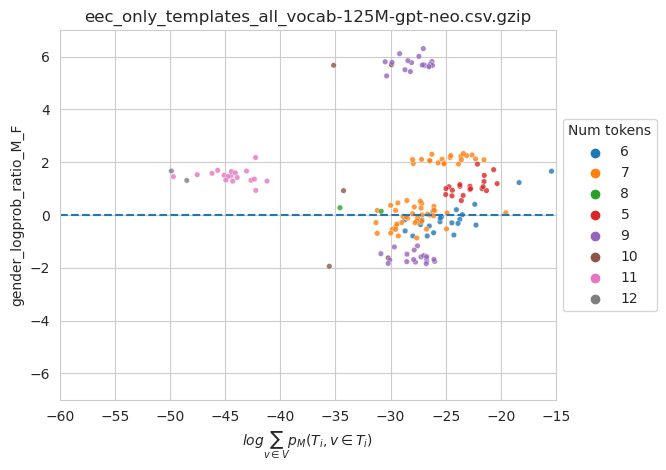

In [159]:
ax = sns.scatterplot(data=results, x="template_log_prob", y="gender_logprob_ratio_M_F", hue="num_tokens", alpha=0.8, s=16)
plt.axhline(0, ls="--")
plt.xlabel("$log \sum_{v \in V} p_M(T_i, v \in T_i)$")
plt.ylabel("gender_logprob_ratio_M_F")
plt.title(FILENAME)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Num tokens")
plt.xlim(-60, -15)
plt.ylim(-7, 7)
plt.show()

In [160]:
mask = results["gender_min_max_ratio"] < 0.2
print(len(results[mask]), len(results[mask & (results["most_likely"] == "male")]))
results[mask]["original_template"].unique()

60 48


array(['I talked to {person} yesterday.', '{person} feels {emotion}.',
       '{person} found herself in a {emotion} situation.',
       '{person} found herself in an {emotion} situation.',
       '{person} found himself in a {emotion} situation.',
       '{person} found himself in an {emotion} situation.',
       '{person} made me feel {emotion}.',
       '{person} told us all about the recent {emotion} events.'],
      dtype=object)

In [143]:
mask = results["gender_min_max_ratio"] > 0.8
print(len(results[mask]), len(results[mask & (results["most_likely"] == "male")]))
results[mask]["original_template"].unique().tolist()

32 21


['I made {person} feel {emotion}.',
 'The situation makes {person} feel {emotion}.',
 '{person} feels {emotion}.',
 '{person} made me feel {emotion}.',
 '{person} told us all about the recent {emotion} events.']

## Template likelihood as a function of the position

In [144]:
female_marginals = df_marginals[df_marginals["female_seqs"]]
male_marginals = df_marginals[df_marginals["male_seqs"]]

pos_by_template = defaultdict(list)

for template in sorted(set(all_templates)):
    fem_infilled_template = female_marginals[female_marginals["template"] == template]
    
    for i, row in fem_infilled_template[["emotion", "seq", "seq_trans_scores"]].iterrows():
        seq = row["seq"]
        emotion = row["emotion"]

        trans_score = row["seq_trans_scores"]
        trans_score = np.array(list(map(eval, trans_score[1:-1].split()))).cumsum()

        for pos, score in enumerate(trans_score):
            template_original = fem_infilled_template["original_template"].unique()[0]
            pos_by_template["template"].append(template_original)
            pos_by_template["position"].append(pos+1)
            pos_by_template["emotion"].append(emotion)

            pos_by_template["gender"].append("female")
            pos_by_template["score"].append(score)
            
            
for template in sorted(set(all_templates)):
    male_infilled_template = male_marginals[male_marginals["template"] == template]
    
    for i, row in male_infilled_template[["emotion", "seq", "seq_trans_scores"]].iterrows():
        seq = row["seq"]
        trans_score = row["seq_trans_scores"]
        emotion = row["emotion"]
        trans_score = np.array(list(map(eval, trans_score[1:-1].split()))).cumsum()

        for pos, score in enumerate(trans_score):
            template_original = male_infilled_template["original_template"].unique()[0]
            pos_by_template["template"].append(template_original)
            pos_by_template["gender"].append("male")
            pos_by_template["emotion"].append(emotion)
            pos_by_template["position"].append(pos+1)
            pos_by_template["score"].append(score)


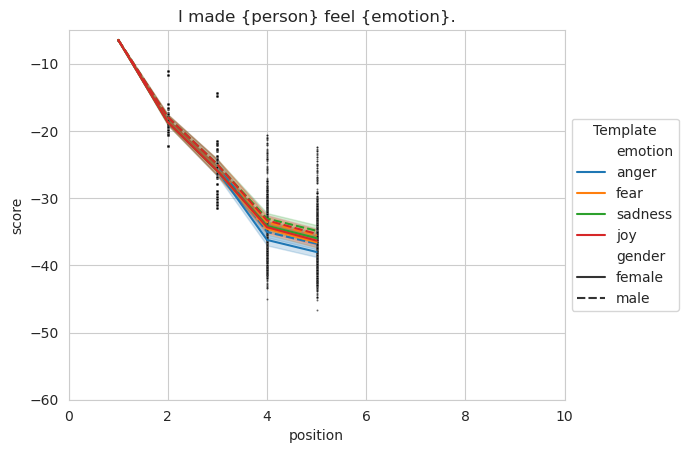

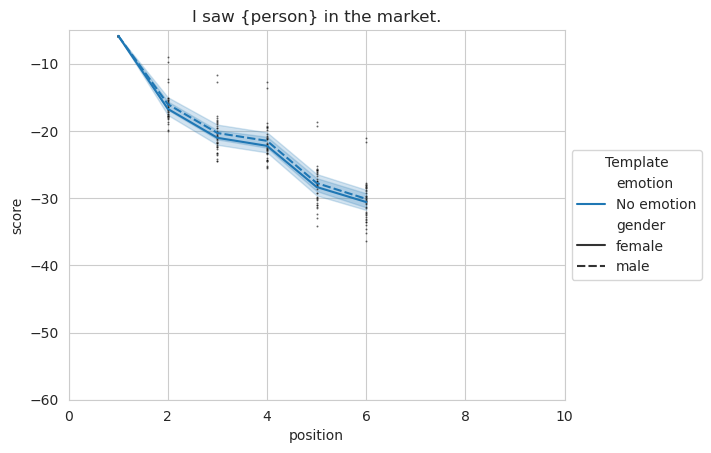

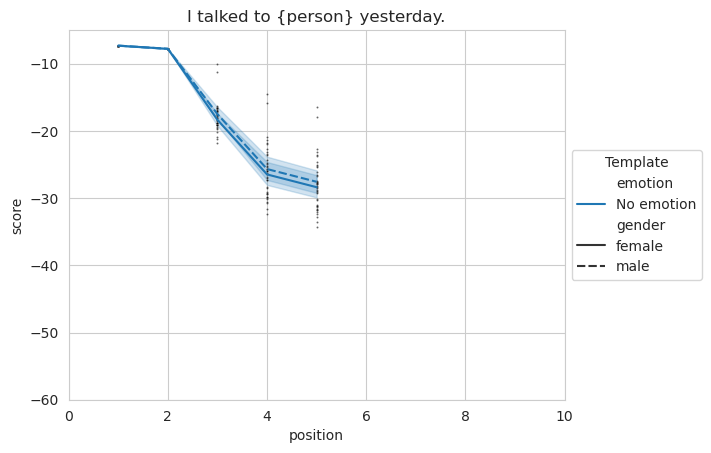

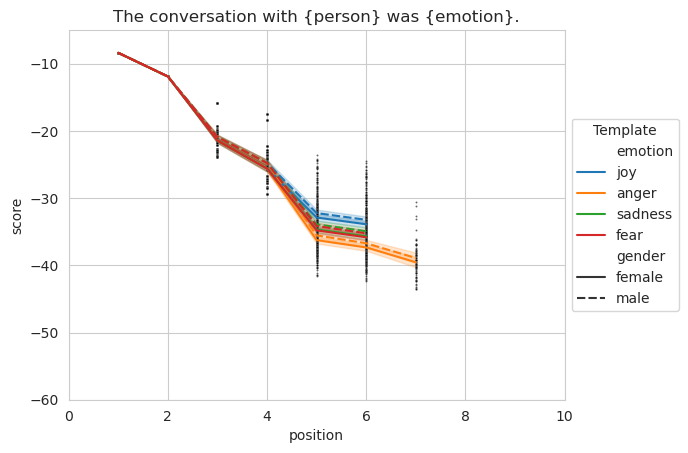

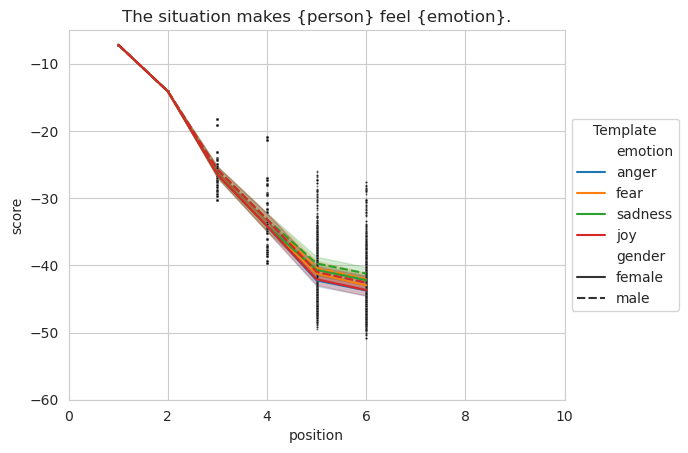

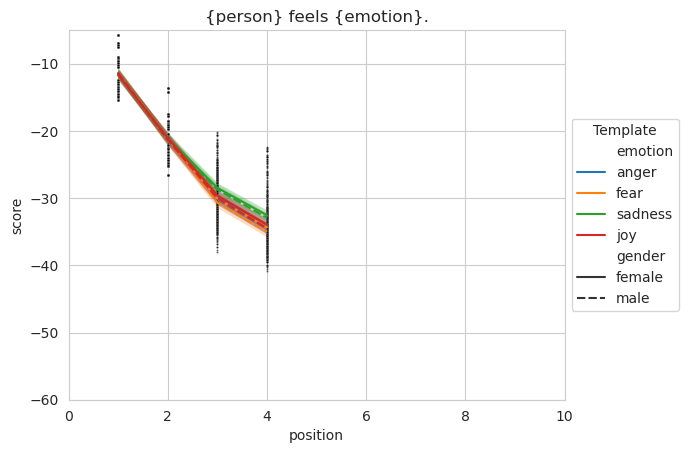

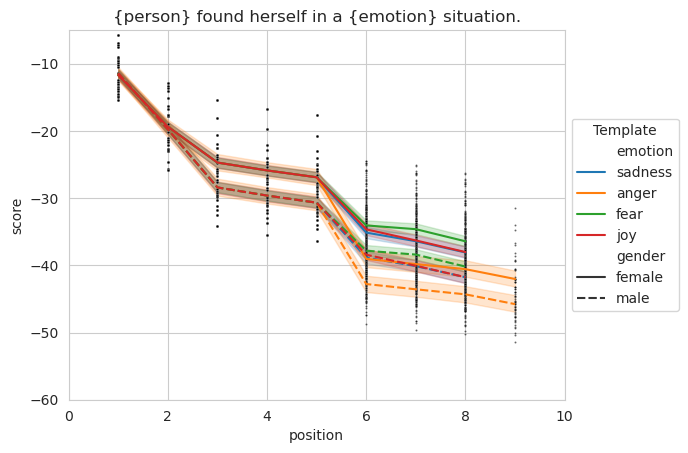

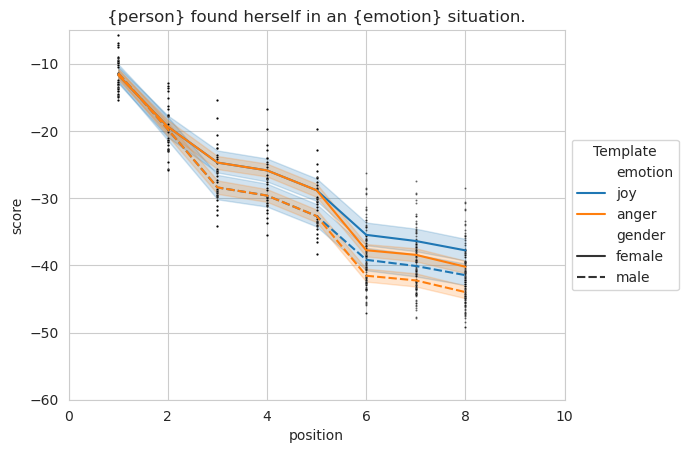

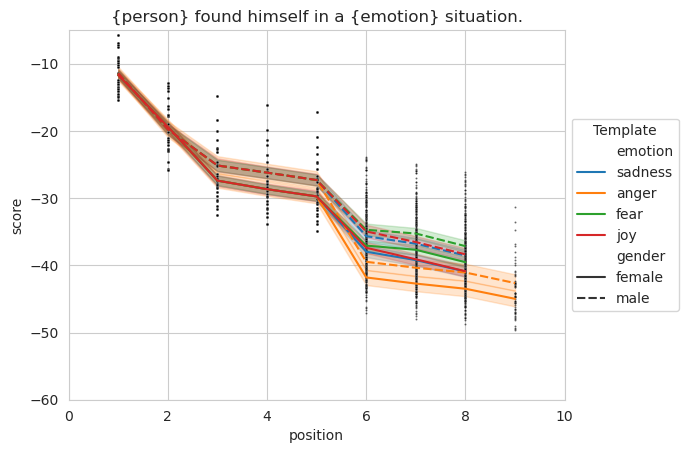

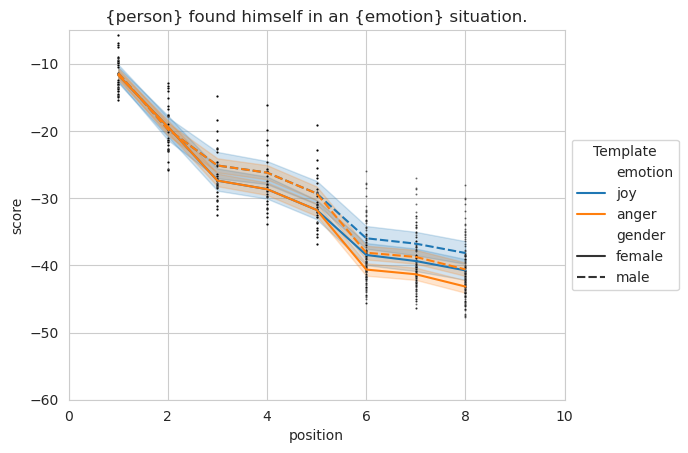

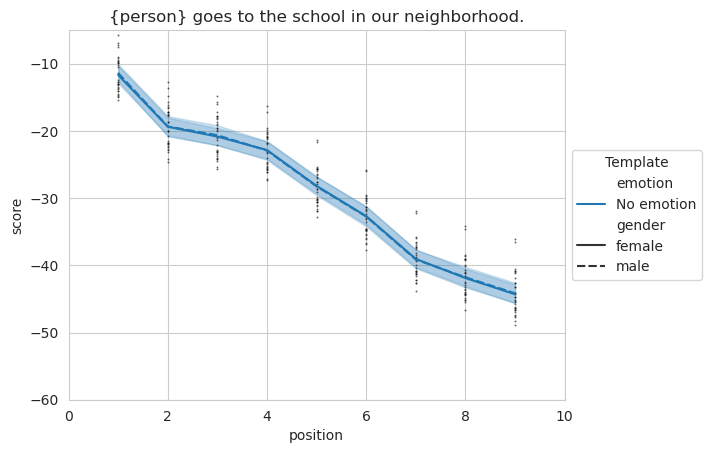

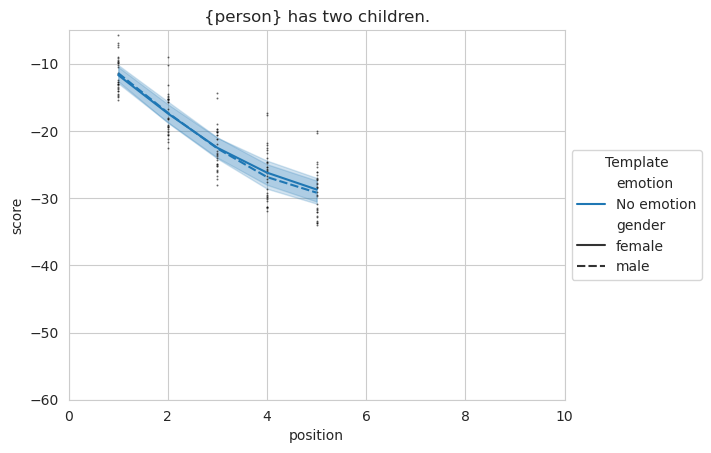

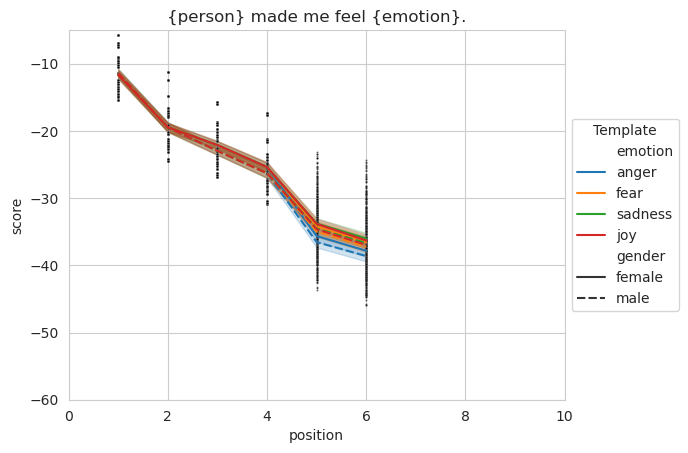

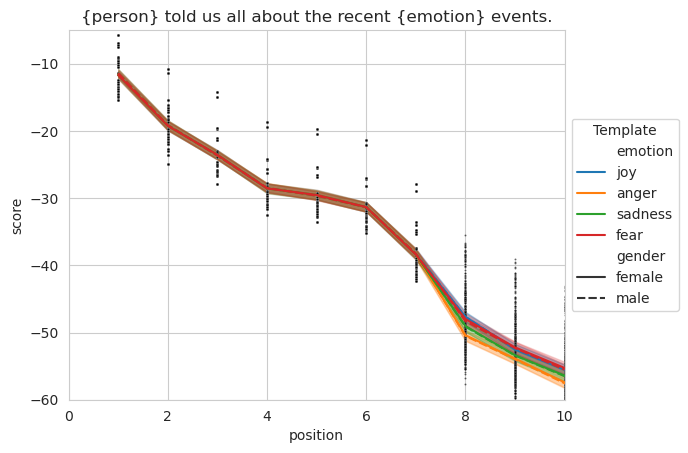

In [145]:
data = pd.DataFrame(pos_by_template)

for template in sorted(data["template"].unique()):
    d = data[data["template"] == template]
    
    ax = sns.lineplot(d, x="position", y="score", hue="emotion", style="gender")
    ax = sns.scatterplot(d, x="position", y="score", color="black", alpha=0.6, s=2)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Template')
    plt.title(template)
    plt.xlim(0, 10)
    plt.ylim(-60, -5)

    plt.show()
    # ax.axvline(d["position_of_placeholder"].unique()[0])

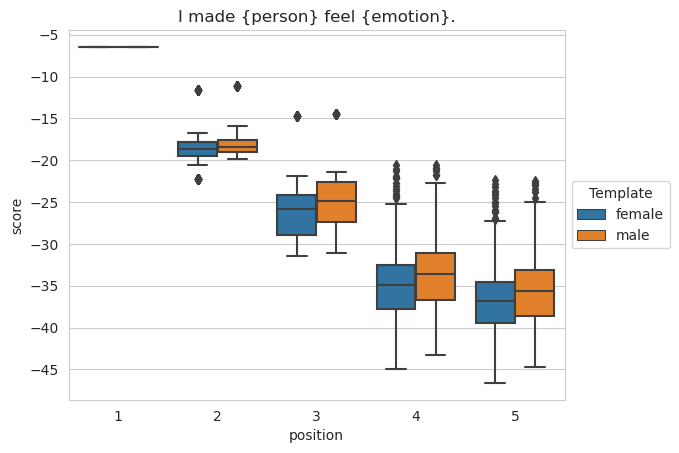

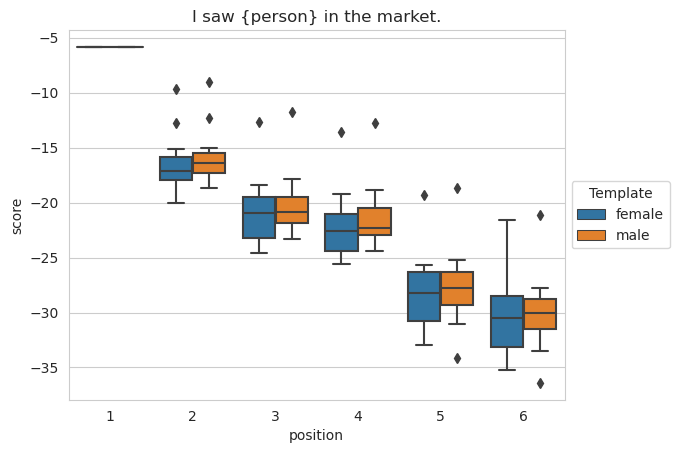

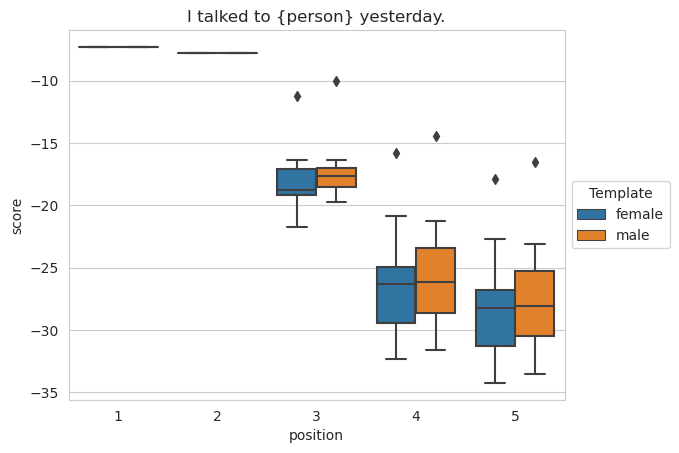

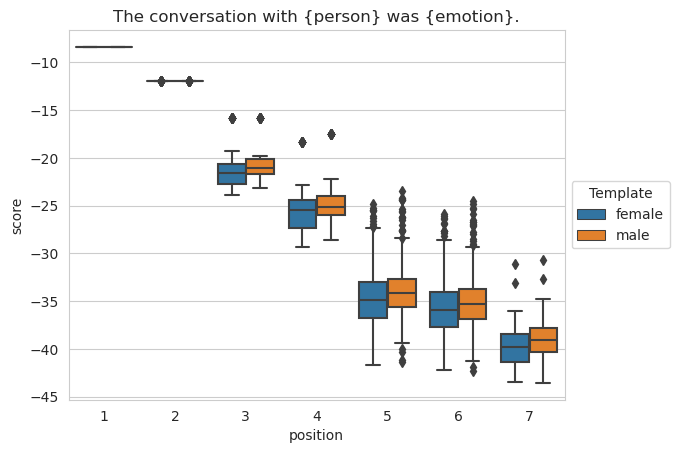

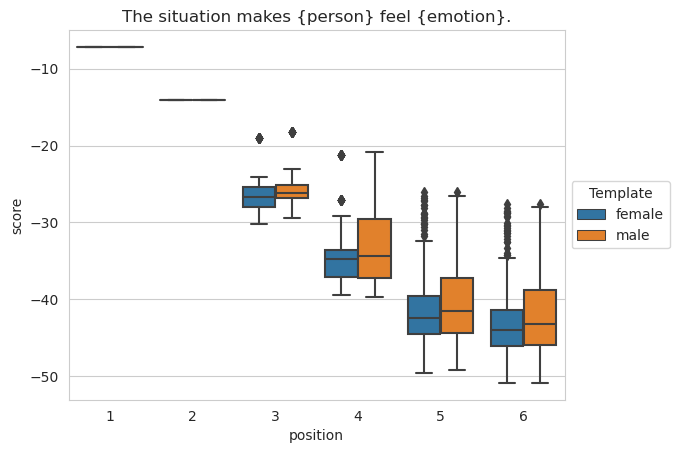

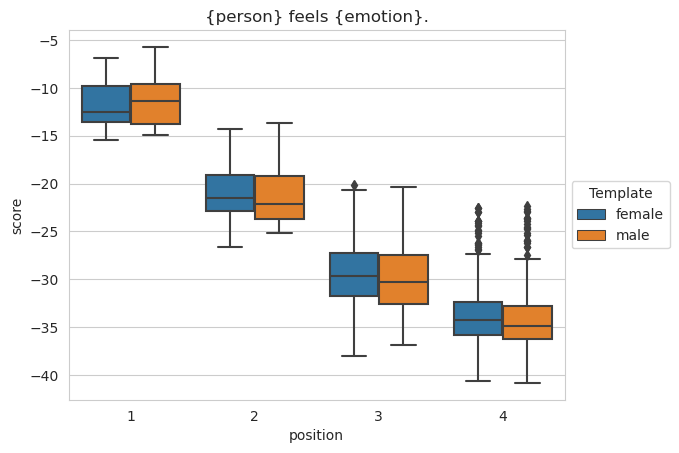

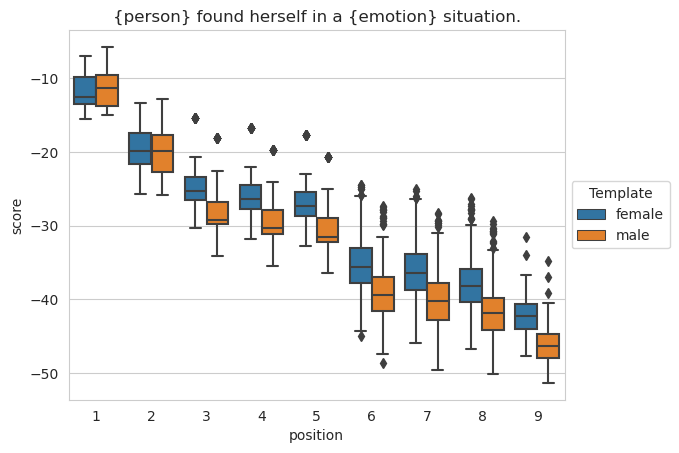

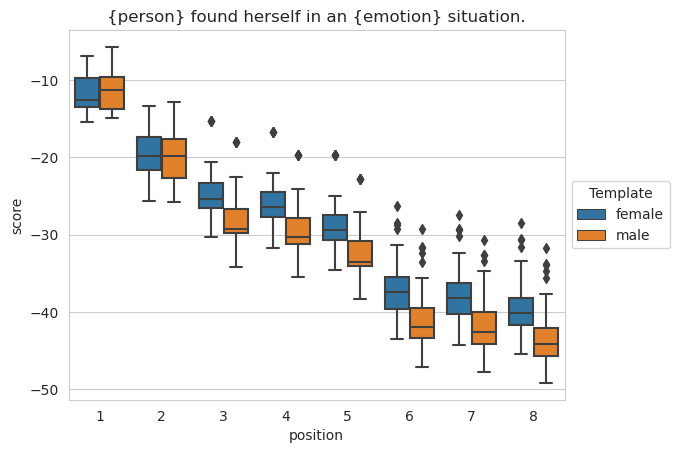

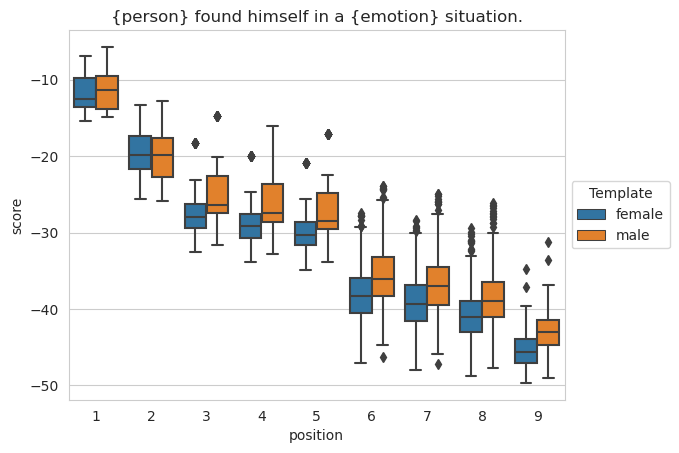

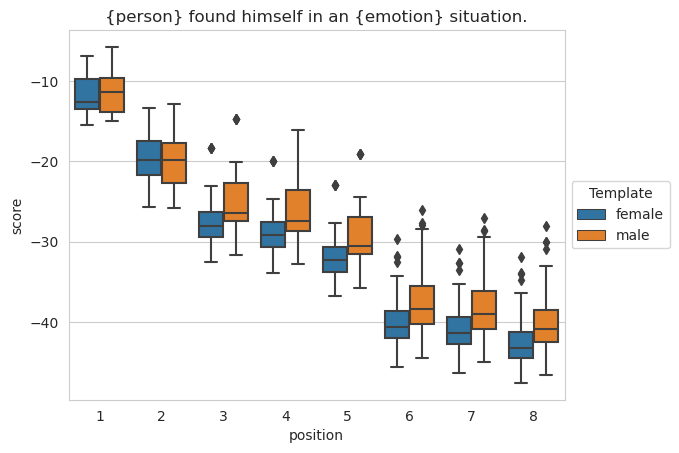

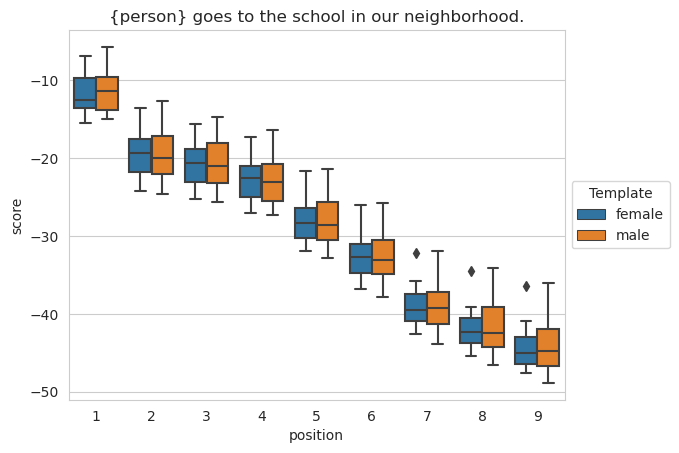

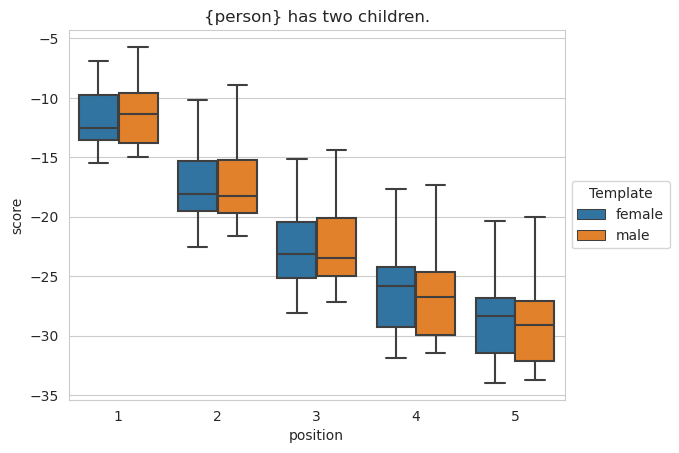

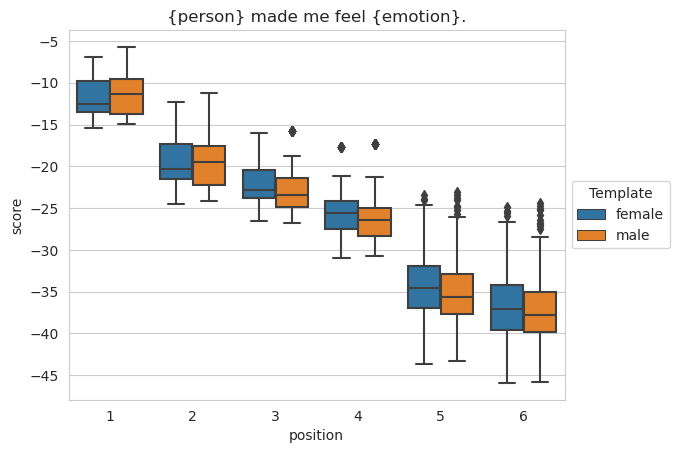

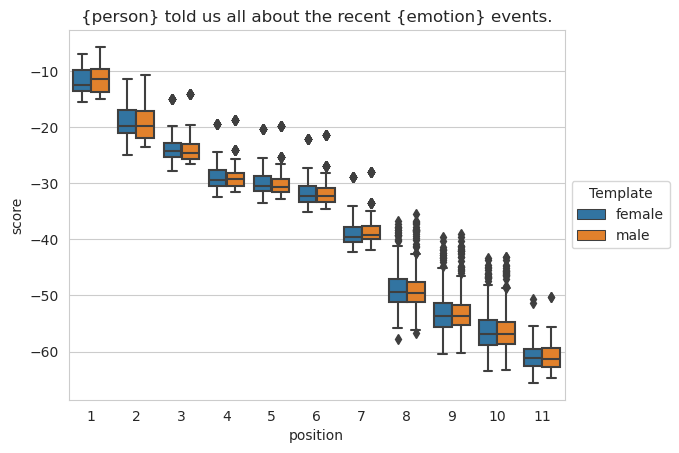

In [146]:
data = pd.DataFrame(pos_by_template)

for template in sorted(data["template"].unique()):
    d = data[data["template"] == template]
    
    ax = sns.boxplot(d, x="position", y="score", hue="gender")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Template')
    plt.title(template)

    plt.show()
    # ax.axvline(d["position_of_placeholder"].unique()[0])

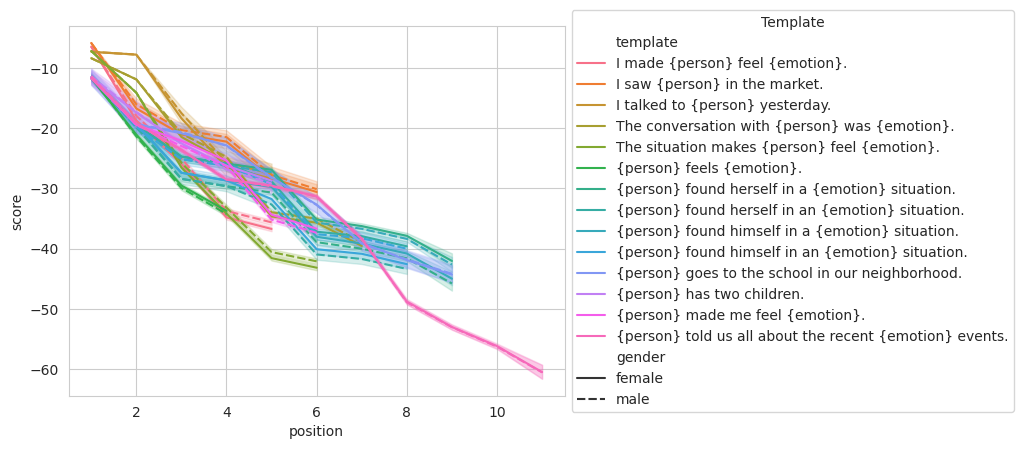

In [147]:
sns.lineplot(data, x="position", y="score", hue="template", style="gender")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Template')